Построить модель машинного обучения, позволяющую предсказать, является ли цветок цветком класса Ирис-Вирджиния или нет

**Задачи:**

In [36]:
import pandas as pd
from sklearn.datasets import load_iris
from pandas import DataFrame
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, mean_squared_error


*1. Из библиотеки scikit-learn подгрузите данные. Мы уже работали с ними в рамках Темы 1.*

Посмотрим ключи, целевые названия ирисов и что у нас в данных и что это за данные

In [37]:
iris = load_iris()

In [38]:
keys = iris.keys()
keys

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [39]:
list(iris.feature_names)

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

Переведем данные в формат DataFrame:

In [40]:
iris_frame = DataFrame(iris.data)
iris_frame.columns = iris.feature_names 
iris_frame['target'] = iris.target
iris_frame['name'] = iris_frame.target.apply(lambda x : iris.target_names[x])
iris_frame.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


In [41]:
iris_frame['name'].value_counts()

name
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

*2. Сформируйте новое поле target_virginica, которое будет равно из 0, если цветок не является классом 2, иначе  — 1. Убедитесь, что разметка выполнена корректно, рассчитав количество объектов каждого класса по новой целевой переменной target_virginica*

In [42]:
iris_frame['target_virginica'] = iris_frame['name'].apply(lambda x: 1 if x == 'virginica' else 0)
iris_frame.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,name,target_virginica
0,5.1,3.5,1.4,0.2,0,setosa,0
1,4.9,3.0,1.4,0.2,0,setosa,0
2,4.7,3.2,1.3,0.2,0,setosa,0
3,4.6,3.1,1.5,0.2,0,setosa,0
4,5.0,3.6,1.4,0.2,0,setosa,0


In [43]:
iris_frame['target_virginica'].value_counts()

target_virginica
0    100
1     50
Name: count, dtype: int64

*3. Обучите библиотечную модель логистической регрессии на обучающей части данных*

In [44]:
X = iris_frame[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'target']]
y = iris_frame['target_virginica']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20)

In [45]:
import numpy as np
print(f"Количество строк в y_train по классам: {np.bincount(y_train)}")
print(f"Количество строк в y_test по классам: {np.bincount(y_test)}")

Количество строк в y_train по классам: [80 40]
Количество строк в y_test по классам: [20 10]


In [46]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [47]:
l_predictions = model.predict(X_test)

In [48]:
model.score(X_test, y_test)

1.0

*4. Оцените качество модели, выведя матрицу ошибок для прогнозов обученной моделью на тестовой части данных.*

In [49]:
lr_probs = model.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
lr_auc = roc_auc_score(y_test, lr_probs)
print('LogisticRegression: ROC AUC=%.3f' % (lr_auc))
fpr, tpr, treshold = roc_curve(y_test, lr_probs)
roc_auc = auc(fpr, tpr)

LogisticRegression: ROC AUC=1.000


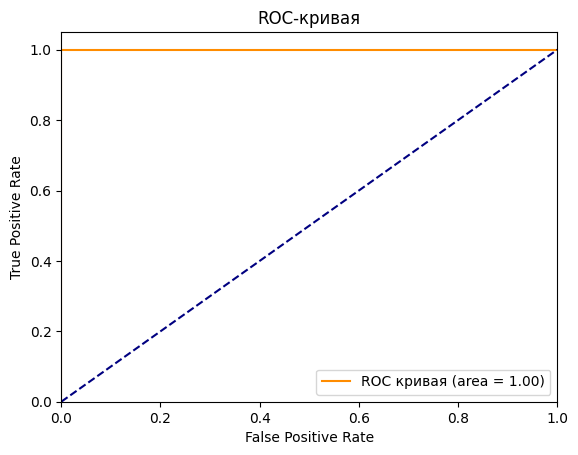

In [50]:
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

Посмотрим матрицу ошибок:

In [51]:
y_pred = model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[20,  0],
       [ 0, 10]], dtype=int64)

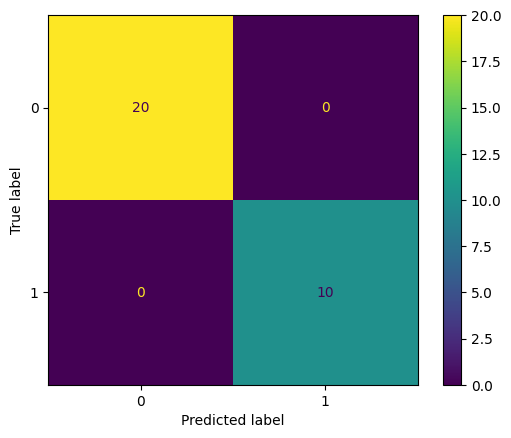

In [52]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
vis = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
vis.plot()
plt.show()

**Получается, модель из библиотеки безошибочно определила все target_virginica**

In [53]:
lin_mae_train = mean_absolute_error(model.predict(X_train), y_train)
print("MAE библиотечной модели на обучающем датасете", lin_mae_train)
lin_mae_val = mean_absolute_error(model.predict(X_test), y_test)
print("MAE библиотечной модели на валидационном датасете", lin_mae_val)

MAE библиотечной модели на обучающем датасете 0.0
MAE библиотечной модели на валидационном датасете 0.0


*5. Сконструируйте свой класс MyLogisticRegression, решающий задачу логистической регрессии методом градиентного спуска*
*   Он должен инициализироваться величиной шага градиентного спуска и количеством итераций градиентного спуска.
*   Должен содержать метод fit для обучения модели, на вход которой будут подаваться обучающие данные. Чтобы реализовать функцию sigmoid, можно воспользоваться библиотечной функцией np.exp. Для расчета градиента необходимо использовать формулу, приведенную в курсе в блоке «Логистическая регрессия для решения задачи бинарной классификации».
*   Должен содержаться метод predict, который будет возвращать лейбл 0/1. Лейбл должен рассчитываться из вероятности принадлежности классу 1. Вероятность должна рассчитываться как сигмоида от результата произведения матрицы фичей X и вектора весов модели w.

*7. Подберите такие параметры градиентного спуска, чтобы разделение получилось не хуже, чем у библиотечной модели.*

In [72]:
class MyLogisticRegression():
    def __init__(self, learning_rate = 0.01, num_iter = 1000):
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.weights = None
        self.bias = None

    def sigmoid(self, s):
        return 1 / (1 + np.exp(-s))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Градиентный спуск
        for _ in range(self.num_iter):
            log_model = np.dot(X, self.weights) + self.bias
            y_pred = self.sigmoid(log_model)

            dw = (1 / n_samples) * np.dot(X.T, y_pred - y)
            db = (1 / n_samples) * np.sum(y_pred - y)
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
    
    def predict (self, X):
        log_model = np.dot(X, self.weights) + self.bias
        y_pred = self.sigmoid(log_model)
        y_pred_cls = [1 if i > 0.5 else 0 for i in y_pred]
        return np.array(y_pred_cls)
    

In [73]:
model_my = MyLogisticRegression()
model_my.fit(X_train.values, y_train.values)

*6. Оцените качество модели, выведя матрицу ошибок для прогнозов обученной моделью на тестовой части данных.*

In [81]:
lr_probs_2 = model_my.predict(X_test)
lr_auc_2 = roc_auc_score(y_test, lr_probs_2)
print('LogisticRegression: ROC AUC=%.3f' % (lr_auc_2))
fpr_2, tpr_2, treshold_2 = roc_curve(y_test, lr_probs_2)
roc_auc_2 = auc(fpr_2, tpr_2)

LogisticRegression: ROC AUC=1.000


Посмотрим матрицу ошибок по сконструированной нами модели (классу):

In [82]:
confusion_matrix(y_test, lr_probs_2)

array([[20,  0],
       [ 0, 10]], dtype=int64)

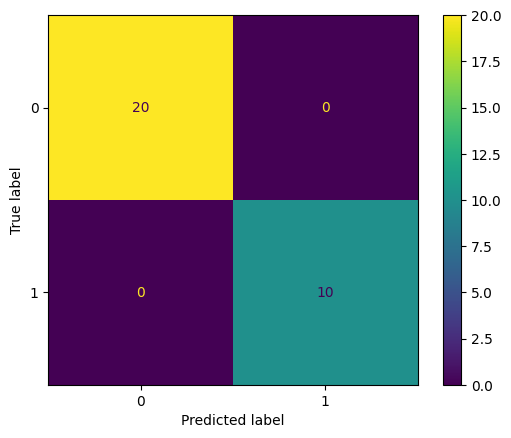

In [80]:
conf_matrix_2 = confusion_matrix(y_true=y_test, y_pred=lr_probs_2)
vis_2 = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_2, display_labels=model.classes_)
vis_2.plot()
plt.show()

In [83]:
lin_mae_train2 = mean_absolute_error(model_my.predict(X_train), model_my.predict(X_train))
print("MAE библиотечной модели на обучающем датасете", lin_mae_train2)
lin_mae_val2 = mean_absolute_error(model_my.predict(X_test), lr_probs_2)
print("MAE библиотечной модели на валидационном датасете", lin_mae_val2)

MAE библиотечной модели на обучающем датасете 0.0
MAE библиотечной модели на валидационном датасете 0.0


**Получается, что наша сконструированния модель (класс) тоже безошибочно определила значения**